In [1]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary
from model import Model_04 as Net

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Test Phase transformations
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

In [4]:
train = datasets.MNIST("./data", train=True, download=True, transform=train_transforms)
test = datasets.MNIST("./data", train=False, download=True, transform=test_transforms)

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = (
    dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True)
    if cuda
    else dict(shuffle=True, batch_size=64)
)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


torch.Size([60000, 28, 28])
torch.Size([28, 60000, 28])
[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


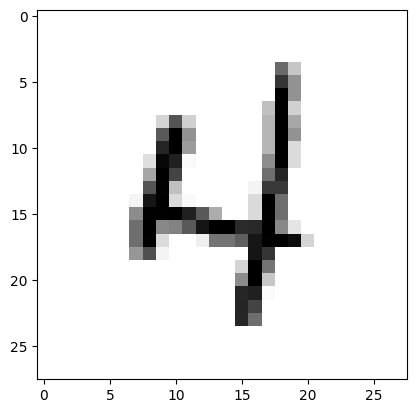

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data = train.transform(train_data.numpy())

print(train.data.shape)
print(train_data.shape)

print('[Train]')
print(' - Numpy Shape:', train.data.cpu().numpy().shape)
print(' - Tensor Shape:', train.data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

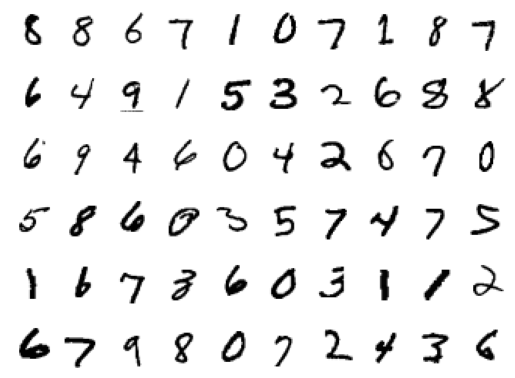

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis("off")
    plt.imshow(images[index].numpy().squeeze(), cmap="gray_r")

# Receptive Field Calculations for all layers.

n_in | RF_in | k | p | s | J_in | J_out | RF_out | n_out | layer
-----|-------|---|---|---|------|-------|--------|-------|---------
28   |   1   | 3 | 0 | 1 | 1    |   1   |   3    |  26   | conv0_0
26   |   3   | 3 | 0 | 1 | 1    |   1   |   5    |  24   | conv1_0
24   |   5   | 3 | 0 | 1 | 1    |   1   |   7    |  22   | conv1_1
22   |   7   | 2 | 0 | 2 | 1    |   2   |   8    |  11   | trans1_pool0
11   |   8   | 1 | 0 | 1 | 2    |   2   |   8    |  11   | trans1_conv0
11   |   8   | 3 | 0 | 1 | 2    |   2   |   12   |  9    | conv2_0
9    |   12  | 3 | 0 | 1 | 2    |   2   |   16   |  7    | conv2_1
7    |   16  | 1 | 0 | 1 | 2    |   2   |   16   |  7    | conv3_0
7    |   16  | 7 | 0 | 1 | 2    |   2   |   28   |  1    | conv3_1

In [8]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
batch_size = 20
s = summary(
    model,
    input_size=(batch_size, 1, 28, 28),
    verbose=1,
    col_names=[
        "kernel_size",
        "input_size",
        "output_size",
        "num_params",
        "mult_adds",
        "trainable",
    ],
    row_settings=["var_names"],
)

cuda
Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Model_04 (Model_04)                      --                        [20, 1, 28, 28]           [20, 10]                  --                        --                        True
├─Sequential (conv0)                     --                        [20, 1, 28, 28]           [20, 10, 26, 26]          --                        --                        True
│    └─Conv2d (0)                        [3, 3]                    [20, 1, 28, 28]           [20, 10, 26, 26]          90                        1,216,800                 True
│    └─ReLU (1)                          --                        [20, 10, 26, 26]          [20, 10, 26, 26]          --                        --                        --
├─Sequential (conv1)                     --                        [20, 10, 26, 26]          [20, 16, 22, 22]   

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_acc = []


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(
            desc=f"Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}"
        )
        train_acc.append(100 * correct / processed)

    # epoch accuracy = accuracy for the whole batch
    epoch_train_acc.append(100 * correct / processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

    test_acc.append(100.0 * correct / len(test_loader.dataset))

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.16295264661312103 Batch_id=468 Accuracy=61.78: 100%|██████████| 469/469 [00:07<00:00, 63.14it/s]


Test set: Average loss: 0.1865, Accuracy: 9428/10000 (94.28%)

EPOCH: 1


Loss=0.1526568979024887 Batch_id=468 Accuracy=95.74: 100%|██████████| 469/469 [00:06<00:00, 68.41it/s]  


Test set: Average loss: 0.0886, Accuracy: 9707/10000 (97.07%)

EPOCH: 2


Loss=0.05261540785431862 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:07<00:00, 66.32it/s] 


Test set: Average loss: 0.0614, Accuracy: 9798/10000 (97.98%)

EPOCH: 3


Loss=0.21109940111637115 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:07<00:00, 63.98it/s] 


Test set: Average loss: 0.0602, Accuracy: 9815/10000 (98.15%)

EPOCH: 4


Loss=0.03244125097990036 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:07<00:00, 65.29it/s] 


Test set: Average loss: 0.0537, Accuracy: 9825/10000 (98.25%)

EPOCH: 5


Loss=0.04927970841526985 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:07<00:00, 64.63it/s]  


Test set: Average loss: 0.0684, Accuracy: 9776/10000 (97.76%)

EPOCH: 6


Loss=0.025725090876221657 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:06<00:00, 67.79it/s]


Test set: Average loss: 0.0515, Accuracy: 9838/10000 (98.38%)

EPOCH: 7


Loss=0.09798187017440796 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:06<00:00, 68.55it/s] 


Test set: Average loss: 0.0510, Accuracy: 9826/10000 (98.26%)

EPOCH: 8


Loss=0.025718437507748604 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:06<00:00, 72.27it/s] 


Test set: Average loss: 0.0465, Accuracy: 9845/10000 (98.45%)

EPOCH: 9


Loss=0.02429046668112278 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:07<00:00, 64.35it/s]  


Test set: Average loss: 0.0424, Accuracy: 9851/10000 (98.51%)

EPOCH: 10


Loss=0.12264882773160934 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:06<00:00, 68.21it/s]  


Test set: Average loss: 0.0437, Accuracy: 9861/10000 (98.61%)

EPOCH: 11


Loss=0.009913441725075245 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:06<00:00, 68.10it/s] 


Test set: Average loss: 0.0397, Accuracy: 9871/10000 (98.71%)

EPOCH: 12


Loss=0.02331540547311306 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:07<00:00, 65.62it/s]  


Test set: Average loss: 0.0425, Accuracy: 9861/10000 (98.61%)

EPOCH: 13


Loss=0.01734722964465618 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:06<00:00, 68.70it/s]  


Test set: Average loss: 0.0481, Accuracy: 9847/10000 (98.47%)

EPOCH: 14


Loss=0.019495079293847084 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:07<00:00, 64.54it/s] 


Test set: Average loss: 0.0454, Accuracy: 9857/10000 (98.57%)



Text(0.5, 1.0, 'Test Accuracy')

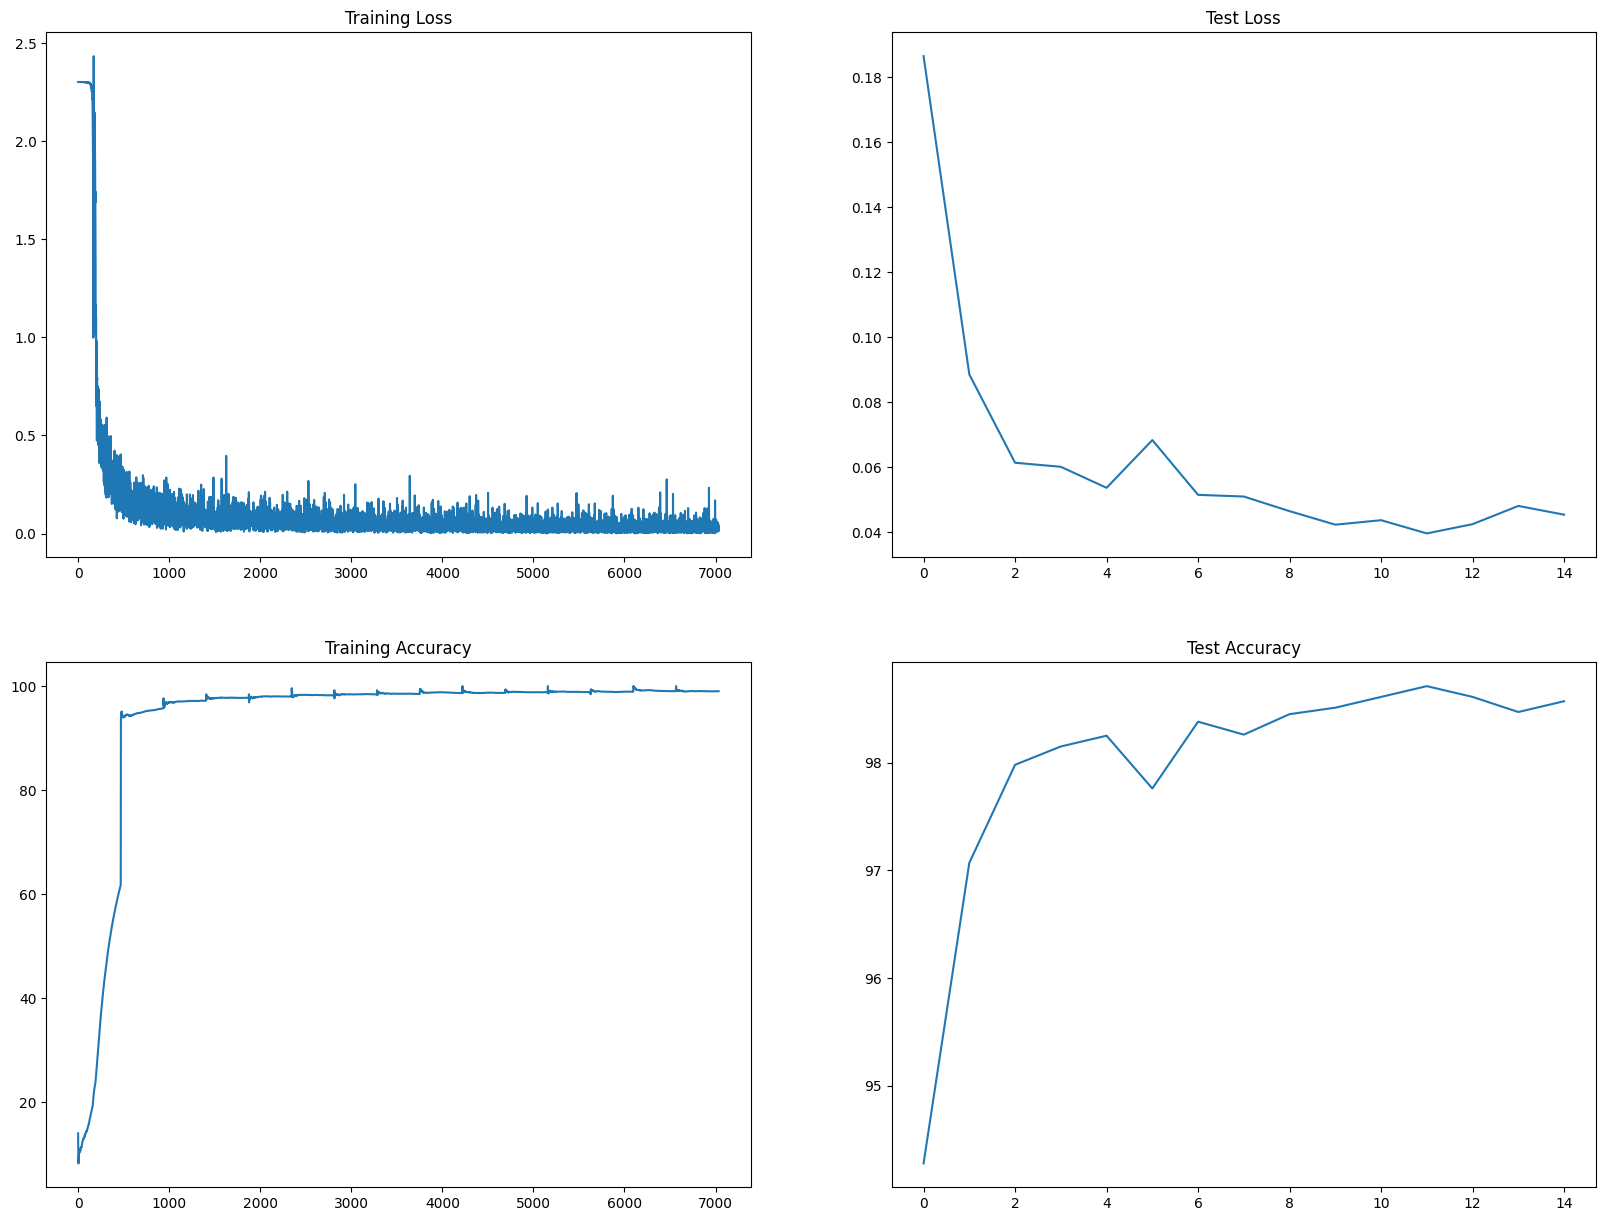

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(20, 15))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [12]:
print("Minimum training loss = {:.9f}%".format(min(train_losses)))
print("Minimum testing loss = {:.9f}%".format(min(test_losses)))
print("Best training accuracy = {:.2f}%".format(max(epoch_train_acc)))
print("Best testing accuracy = {:.2f}%".format(max(test_acc)))

Minimum training loss = 0.000764848%
Minimum testing loss = 0.039680968%
Best training accuracy = 99.03%
Best testing accuracy = 98.71%



# Target:

1.  To make the model even lighter

# Results:

*   Parameters = 9,990
*   Best training accuracy = 99.03%
*   Best testing accuracy = 98.71%

# Analysis:

*   Model has not achieved its target size but it's lighter
*   Model is not over-fitting as evident by the delta in training and testing accuracy. If training accuracy is improved, I can see the model achieving the target testing accuracy